In [1]:
import statsmodels.api as sm
import pandas as pd #librería para manejo de datos
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
import matplotlib.pylab as plt

datos_f1=pd.read_csv('datos/Datos F1_noMulti.csv', sep=';', decimal=',', header=0)

datos_f1


,Tiempo Qualy (milisegundos),Length (m),Curva lenta,Curva media,Curva rapida,Presupuesto (mill. Euros),Asphalt Abrasion,log(aa),log(cl),log(cm),log(cr),A�o,Race,procentaje de tiempo con el acelerador a fondo,porcentaje de tiempo de frenada,Downforce,Tyre Stress,Lateral energy,Asphalt Grip
0,83.485,5.303,6,4,5,429.5,3,0.477121,0.778151,0.602060,0.698970,2017,Australia,64,13.0,4,1,2,1
1,81.879,5.303,6,4,5,350.0,3,0.477121,0.778151,0.602060,0.698970,2018,Australia,64,13.0,4,1,2,1
2,81.320,5.303,6,4,5,260.0,3,0.477121,0.778151,0.602060,0.698970,2019,Australia,64,13.0,4,1,2,1
3,69.687,5.412,3,7,2,429.5,5,0.698970,0.477121,0.845098,0.301030,2017,Bahrain,64,16.0,2,3,3,4
4,69.378,5.412,3,7,2,350.0,5,0.698970,0.477121,0.845098,0.301030,2018,Bahrain,64,16.0,2,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,67.778,4.309,1,6,7,350.0,3,0.477121,0.000000,0.778151,0.845098,2018,Brazil,60,16.0,4,3,4,3
59,67.508,4.309,1,6,7,260.0,3,0.477121,0.000000,0.778151,0.845098,2019,Brazil,60,16.0,4,3,4,3
60,97.328,5.554,8,5,4,429.5,2,0.301030,0.903090,0.698970,0.602060,2017,Abu Dhabi,60,17.0,3,2,3,2
61,95.589,5.554,8,5,4,350.0,2,0.301030,0.903090,0.698970,0.602060,2018,Abu Dhabi,60,17.0,3,2,3,2


In [3]:
list(datos_f1.columns)

['Tiempo Qualy (milisegundos)',
 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Presupuesto (mill. Euros)',
 'Asphalt Abrasion',
 'log(aa)',
 'log(cl)',
 'log(cm)',
 'log(cr)',
 'A�o',
 'Race',
 'procentaje de tiempo con el acelerador a fondo',
 'porcentaje de tiempo de frenada',
 'Downforce',
 'Tyre Stress',
 'Lateral energy',
 'Asphalt Grip']

In [32]:
X=datos_f1[[ 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Asphalt Grip',
 'Asphalt Abrasion']]
X = X.astype('float64')
y=datos_f1.values[:,0]
y = y.astype('float64')
#print(X)
mco1 = sm.OLS(y, sm.add_constant(X)).fit()

mco1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     52.78
Date:                Tue, 30 Nov 2021   Prob (F-statistic):           2.85e-21
Time:                        09:16:42   Log-Likelihood:                -189.52
No. Observations:                  63   AIC:                             393.0
Df Residuals:                      56   BIC:                             408.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               13.6538      5.015      2.723      0.009       3.607      23.700
Length (m)          11.4054      0.978     11.661      0.000       9.446      13.365
Curva lenta          3.0251      0.343      8.808      0.000       2.337       3.713
Curva media         -1.4984      0.549     -2.728      0.008      -2.599      -0.398
Curva rapida         0.5889      0.400      1.472      0.147      -0.212       1.390
Asphalt Grip         4.1230      1.047      3.939      0.000       2.026       6.220
Asphalt Abrasion    -3.1871      0.880     -3.623      0.001      -4.949      -1.425
==============================================================================
Omnibus:                       32.534   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.414
Skew:                           1.651   Prob(JB):                     1.14e-16
Kurtosis:                       7.130   Cond. No.                         82.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [33]:
beta=mco1.params
e=mco1.resid
beta=np.array(mco1.params)
#print(e)
sum(e**2)/(mco1.nobs-1)
print()
# sigmagorro=(np.dot(y, y)-np.dot(beta.T, np.dot(X.T, y))) / (mco1.nobs-1)
# print(sigmagorro)

## HETEROSCEDASTICIDAD

In [12]:
GQ=sms.het_goldfeldquandt(mco1.model.endog, mco1.model.exog, split=3) #Split es para que se quede con una tercera parte o lo que queramos
print('Het-Goldfelquandt', GQ)#El SPLIT 3 no se puede poner porque debe dar un valor entero. Por defecto lo hace entre 2
#El vector te da en el 2 valor el p valor, si tu alfa es menor que el p valor significa HOMOSCEDASTICIDAD

BP=sms.het_breuschpagan(mco1.resid, mco1.model.exog)
print('Het-Breuschpagan', BP)
#Este nos decía cuanto dependía nuestros residuos al cuadrado respecto de nuestras vbles. Sólo nos interesan los
#dos ultimos valores que son el estadístico experimental y el p valor. Como es mayor que nuestro alfa (0.05) hay HOMOSCEDASTICIDAD
WH=sms.het_white(mco1.resid, mco1.model.exog)
print('Het-Whithe', WH) #Igual, nos interesan sólo los dos últimos valores y significan lo mismo que en el anterior. 



Het-Goldfelquandt (107.76684315728731, 9.446249988747399e-14, 'increasing')
Het-Breuschpagan (12.282140420325984, 0.4232949362018341, 1.0090249373457596, 0.4550016997755348)
Het-Whithe (26.17690631055308, 0.7945305319807839, 0.6247152442944426, 0.9040299420162615)


## Glejser

In [13]:
import statsmodels.stats.outliers_influence as oi

#Para la primera variable
#1-(1-(R^2)) = 284 ; R = 0.9964
#Se podria decir que el tamanio dle edificio lo puedo escribir en funcion de las otas 2 variables

#Factor de inflacion de la varianza, con el for hacemos que salga  para toda las variables
vifs=[oi.variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
#Hay problema de multicolinealidad, si vif es mayor que 10 y si es mayor que 20, problema grave
#HAY MULTICOLINEALIDAD
vifs

Length (m)
h:  -2 -> pval: 0.6472720112044562  R2:  0.003454336455031126
h:  -1 -> pval: 0.5012497561265785  R2:  0.00744769154672098
h:  -0.5 -> pval: 0.432201283373963  R2:  0.010144482720637171
h:  0.5 -> pval: 0.30894740204941507  R2:  0.01696393114093142
h:  1 -> pval: 0.25649305594628463  R2:  0.02105654523736289
h:  2 -> pval: 0.17149822844039392  R2:  0.03043138913741228
Curva lenta
h:  -2 -> pval: 0.8708189142451439  R2:  0.0004369925358532756
h:  -1 -> pval: 0.9743900679735642  R2:  1.7033818050848915e-05
h:  -0.5 -> pval: 0.8449016815582742  R2:  0.0006323424950215317
h:  0.5 -> pval: 0.612356553793141  R2:  0.004234777315744509
h:  1 -> pval: 0.5692349710432449  R2:  0.005340267879518801
h:  2 -> pval: 0.6162996444712464  R2:  0.004141704980662464
Curva media
h:  -2 -> pval: 0.3170981195205708  R2:  0.016406608010961055
h:  -1 -> pval: 0.20116937992091732  R2:  0.026643234843875208
h:  -0.5 -> pval: 0.1668271491993237  R2:  0.03109503257292312
h:  0.5 -> pval: 0.13291663497

[41.28812918135159,
 7.949618256746982,
 19.351884667157172,
 6.36234153030487,
 20.563114067024074,
 13.616582053542007]

In [34]:
import numpy as np
#Matriz de correlacciones
corr_matrix=np.corrcoef(X.T) #X.T = matriz X traspuesta
print(corr_matrix)

#Lo ideal es que la matriz fuese la identidad

[[ 1.          0.00753052  0.13372822  0.29054151  0.36949531  0.46805826]
 [ 0.00753052  1.         -0.06111079 -0.39084757 -0.50398903 -0.12775327]
 [ 0.13372822 -0.06111079  1.         -0.24789618  0.4831656   0.22624666]
 [ 0.29054151 -0.39084757 -0.24789618  1.          0.18379252  0.17162219]
 [ 0.36949531 -0.50398903  0.4831656   0.18379252  1.          0.59086427]
 [ 0.46805826 -0.12775327  0.22624666  0.17162219  0.59086427  1.        ]]


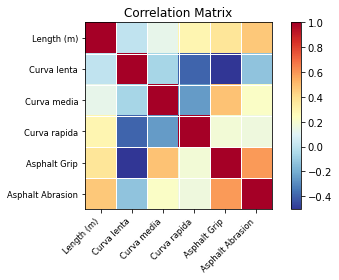

In [36]:
import statsmodels.graphics.api as smg
smg.plot_corr(corr_matrix, xnames=[ 'Length (m)',
 'Curva lenta',
 'Curva media',
 'Curva rapida',
 'Asphalt Grip',
 'Asphalt Abrasion'])
plt.show()